In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum,count,round , lit,when,substring,avg,countDistinct,floor,max,min,percentile_approx

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import locale
import pandas as pd
import plotly.express as px
import time
import os

# Pré-processamento
from pyspark.ml.feature import StringIndexer, OneHotEncoder as OneHotEncoderSpark, VectorAssembler, MinMaxScaler as MinMaxScalerSpark,RobustScaler,VectorAssembler


from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Clusterização Hierárquica
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
# Clusterização K-Means
from sklearn.cluster import KMeans
# Métrica de qualidade de clusters
from sklearn.metrics import silhouette_score


caminho =r'D:/base_ans_parquet/'

anos_filtrar = ["2023", "2024", "2025"]

arquivos_parquet = [
    os.path.join(caminho, f)
    for f in os.listdir(caminho)
    if f.endswith(".parquet") and any(ano in f for ano in anos_filtrar)
]

spark = SparkSession.builder \
    .appName("LeituraParquet") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "8g") \
    .getOrCreate()
inicio = time.time()

spark.conf.set("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true")

df = spark.read.parquet(*arquivos_parquet)
total_registros = df.count()  # Força leitura e conta registros
fim = time.time()

print(f"Total de registros: {total_registros}")
print(f"Tempo de leitura: {fim - inicio:.2f} segundos")

Total de registros: 421212923
Tempo de leitura: 2.59 segundos


In [23]:
#FILTRAR DADOS
df_soma0 = df.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma0.show()
#FILTRAR APENAS USUARIOS DE PLANO DE SAUDE, EXCLUIR ODONTOLOGICO 
df_filtrado = df.filter(
    (col("COBERTURA_ASSIST_PLAN") == "Médico-hospitalar")     
)
df_soma = df_filtrado.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma.show()


#REMOVER USUARIOS SEM FAIXA ETARIA, SEM VINCULO
df_filtrado2345 = df_filtrado.filter(
    (col("DE_FAIXA_ETARIA") != "Informada Incorr") &
    (col("TIPO_VINCULO") != "Não Identificado") &
    (col("SG_UF") != "XX") &
    (col("DE_CONTRATACAO_PLANO") != "Não Identificado")
)
df_soma2 = df_filtrado2345.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma2.show()

df_filtrado6 = df_filtrado2345.filter(
    col("ID_CMPT_MOVEL").isin("2025-05")
)


colunas_ok = [
    "ID_CMPT_MOVEL", "NM_RAZAO_SOCIAL", "SG_UF",
    "TP_SEXO", "DE_FAIXA_ETARIA", "DE_FAIXA_ETARIA_REAJ",
    "DE_CONTRATACAO_PLANO", "TIPO_VINCULO",
    "QT_BENEFICIARIO_ATIVO", "QT_BENEFICIARIO_ADERIDO", "QT_BENEFICIARIO_CANCELADO"
]

# Colunas numéricas que vamos somar
colunas_numericas = [
    "QT_BENEFICIARIO_ATIVO", "QT_BENEFICIARIO_ADERIDO", "QT_BENEFICIARIO_CANCELADO"
]

colunas_grupo = list(set(colunas_ok) - set(colunas_numericas))

df_filtrado6a = df_filtrado6.groupBy(colunas_grupo).agg(
    *[sum(col).alias(col) for col in colunas_numericas]
)

# Exibe o resultado
#df_filtrado6a.show(truncate=False)

df_somagroupby = df_filtrado6a.groupBy("DE_FAIXA_ETARIA_REAJ", "TIPO_VINCULO").agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_valor"))

df_filtrado7 = df_filtrado6a.filter(
    (col("ID_CMPT_MOVEL")=="2025-05") &
    (col("NM_RAZAO_SOCIAL")=="BRADESCO SAÚDE S.A." ) #&
    #(col("SG_UF").isin("PR","SC","RS"))
    
)

#df_filtrado7.show()



In [24]:
qtde=df_filtrado7.count()
print ({qtde})

{6073}


In [40]:
# 4. Selecionar colunas numéricas e categóricas
col_numericas = [
    "QT_BENEFICIARIO_ATIVO",
    "QT_BENEFICIARIO_ADERIDO",
    "QT_BENEFICIARIO_CANCELADO"
]
col_categoricas = [
    "TIPO_VINCULO",
    "DE_FAIXA_ETARIA",
    "TP_SEXO"#,
    #"DE_CONTRATACAO_PLANO"
]


# Atualizar lista de colunas escalonadas
col_numericas_scaled = [f"{col}_scaled" for col in col_numericas]

# 5. StringIndexer + OneHotEncoder para cada coluna categórica
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx") for col in col_categoricas]

# OneHotEncoder para múltiplas colunas (PySpark 4.0)
encoder = OneHotEncoderSpark(
    inputCols=[f"{col}_idx" for col in col_categoricas],
    outputCols=[f"{col}_vec" for col in col_categoricas],
    handleInvalid="keep"
)

# Pipeline de transformação
pipeline = Pipeline(stages=indexers + [encoder])
df_encoded = pipeline.fit(df_filtrado7).transform(df_filtrado7)

# Junta tudo num vetor de features
input_features = col_numericas + [f"{col}_vec" for col in col_categoricas]
assembler = VectorAssembler(inputCols=input_features, outputCol="features_raw")
df_vector = assembler.transform(df_encoded)

# Escalona com MinMaxScaler
scaler = MinMaxScalerSpark(inputCol="features_raw", outputCol="features_scaled")
#robust_scaler = RobustScaler(inputCol="features_raw", outputCol="features_scaled")

df_scaled = scaler.fit(df_vector).transform(df_vector)

# Coleta os dados como vetores NumPy para clusterização fora do Spark
X = df_scaled.select("features_scaled").rdd.map(lambda row: row["features_scaled"].toArray()).collect()


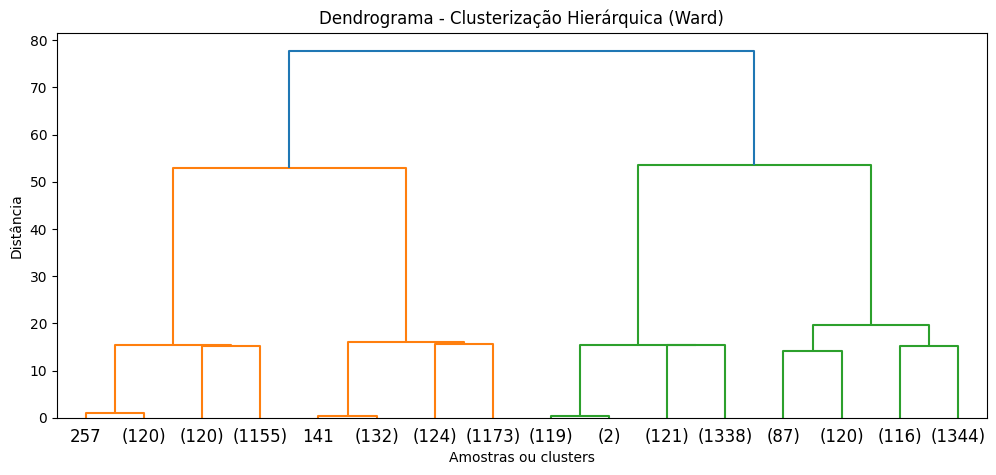

Tipo de X: <class 'numpy.ndarray'>, Formato: (6073, 26)
Tipo de labels_hier: <class 'numpy.ndarray'>, Formato: (6073,)

RESULTADOS FINAIS:
Número de clusters: 4
Silhouette Score: 0.3033
Inércia total: 5955.3252
Cluster 1 - Centróide: [0.01097889 0.0072094  0.00828046 0.         1.         0.08595989
 0.08166189 0.08667622 0.08166189 0.07951289 0.0773639  0.07879656
 0.05945559 0.04011461 0.05444126 0.05014327 0.05444126 0.0508596
 0.05157593 0.01934097 0.01575931 0.01432665 0.00787966 0.01002865
 0.         1.        ]
Cluster 2 - Centróide: [0.01576196 0.01269879 0.01529027 0.0041958  0.9958042  0.09300699
 0.08251748 0.08601399 0.08181818 0.08671329 0.08251748 0.07832168
 0.06083916 0.03706294 0.05174825 0.05174825 0.04965035 0.05034965
 0.05034965 0.01678322 0.01328671 0.01258741 0.00979021 0.0048951
 0.99440559 0.00559441]
Cluster 3 - Centróide: [0.01087153 0.00560364 0.00773558 1.         0.         0.07658228
 0.07594937 0.07658228 0.07531646 0.07594937 0.0721519  0.06962025
 0.0

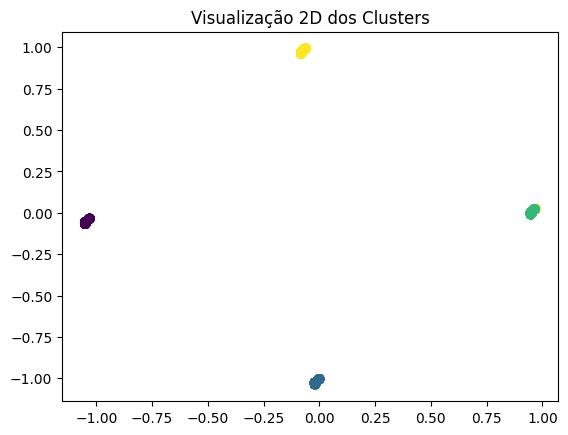

In [43]:

# Cria o linkage e plota o dendrograma
#h_cluster = linkage(X, method='ward')
h_cluster = linkage(X, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(h_cluster, truncate_mode='level', p=3)
plt.title("Dendrograma - Clusterização Hierárquica (Ward)")
plt.xlabel("Amostras ou clusters")
plt.ylabel("Distância")
plt.show()

# 1. Garantir que os dados estejam no formato correto
X = np.asarray(X)  # Converte para array numpy se não for
print(f"Tipo de X: {type(X)}, Formato: {X.shape}")

# 2. Obter os clusters
k_hier = 4
labels_hier = fcluster(h_cluster, k_hier, criterion='maxclust')
labels_hier = np.asarray(labels_hier)  # Garante que seja numpy array
print(f"Tipo de labels_hier: {type(labels_hier)}, Formato: {labels_hier.shape}")

# 3. Cálculo da inércia - abordagem robusta
inertia_hier = 0

for cl in np.unique(labels_hier):
    # Converter para lista de índices se necessário
    mask = (labels_hier == cl)
    cluster_points = X[mask]
    
    # Verificação de segurança
    if len(cluster_points) == 0:
        continue
        
    centroid = np.mean(cluster_points, axis=0)
    inertia_hier += np.sum((cluster_points - centroid) ** 2)

# 4. Cálculo do Silhouette Score
sil_score_hier = silhouette_score(X, labels_hier)

print("\nRESULTADOS FINAIS:")
print(f"Número de clusters: {k_hier}")
print(f"Silhouette Score: {sil_score_hier:.4f}")
print(f"Inércia total: {inertia_hier:.4f}")


for cl in np.unique(labels_hier):
    print(f"Cluster {cl} - Centróide:", X[labels_hier == cl].mean(axis=0))


    
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_hier, cmap='viridis')
plt.title('Visualização 2D dos Clusters')
plt.show()

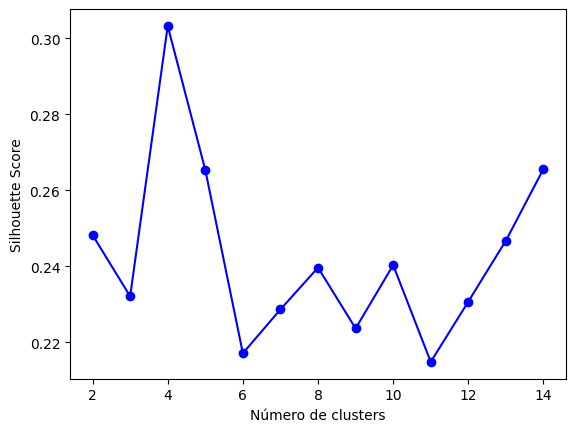

In [42]:
# Avalie diferentes números de clusters
range_n_clusters = range(2, 15)
silhouette_scores = []

for n_clusters in range_n_clusters:
    labels = fcluster(h_cluster, n_clusters, criterion='maxclust')
    silhouette_scores.append(silhouette_score(X, labels))

plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.show()